Copyright (C) 2023 Ming-Fong Sie <seansie07@gmail.com> & Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd
import pickle
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tqdm import tqdm

from learn import get_model, get_params
from utils import run_from_ipython, np2df
from viz import show_cm_list, show_rp_list

if run_from_ipython():
    import matplotlib
    # %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    import xgboost
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [2]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--model', '-m', help='model/method', type=str,
                        choices=['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'], default='xgb')
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bem')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--n_jobs', '-j', help='number of workers/threads; set -1 to use all processors', type=int, default=10)
    parser.add_argument('--no_cost_sentitive', help='disable cost sentitive learning', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bem', model='xgb', n_folds=10, n_jobs=10, no_cost_sentitive=False, output='./data_p', result='./result', scheme='address')


In [3]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
model = args.model                           # 'lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
n_jobs = args.n_jobs                         # -1 to use all processors, or any positive integer
cost_sensitive = not args.no_cost_sentitive  # True, False
output_path = args.output
result_path = args.result

# Check the experiment setting

assert model in ['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb']
assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
# assert scheme in ['address', 'entity']
assert scheme in ['address']

# Show the experiment setting

print('Experiment Setting')
print('===> Model:         ', model)
print('===> Feature Types: ', feature_type)
print('===> Data Scheme:   ', scheme)
print('===> Cost Sensitive:', cost_sensitive)
print('===> N Threads:     ', n_jobs)

Experiment Setting
===> Model:          xgb
===> Feature Types:  bem
===> Data Scheme:    address
===> Cost Sensitive: True
===> N Threads:      10


In [4]:
# Load transaction history summarization data

# data_file = 'data.{}.csv'.format(scheme)
# data_file = 'quantum_qubo_data.{}.csv'.format(scheme)
data_file = 'all_selected_features_quantum_qubo_data.{}.csv'.format(scheme)
data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(4)
else:
    print(data.head(4))

      n_tx  total_days  total_spent_btc  total_received_btc  total_spent_usd  \
0      1.0         1.0         0.010000            0.010000         2.756730   
1      1.0         1.0         0.011000            0.011000         2.462163   
2      1.0         1.0         0.010000            0.010000         3.279240   
3      1.0         1.0         0.010521            0.010521         3.947436   
4      1.0         1.0         0.010001            0.010001         2.734935   
...    ...         ...              ...                 ...              ...   
6631   1.0         1.0         1.000000            1.000000       219.158997   
6632   8.0        70.0         2.071500            2.071500       496.212535   
6633   2.0         2.0         0.360000            0.360000       138.339377   
6634  15.0        90.0        21.957800           21.957800      5390.795085   
6635   1.0         1.0         4.873600            4.873600      1826.552194   

      total_received_usd  mean_balance_

In [5]:
# Define 3 types of features (basic statistics, extra statistics, and moments)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values
print (features)
print (feature_type)
print (X)
print (y)

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
print (class_names)
y_names = class_names
# y_names = class_names[y]
# y_names = np.array(class_names)[y.astype(int)]

print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

['f_tx', 'f_received', 'f_coinbase', 'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0', 'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4', 'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2', 'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2', 'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6', 'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent', 'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback', 'total_spent_btc', 'total_received_btc', 'total_spent_usd', 'total_received_usd', 'mean_balance_btc', 'std_balance_btc', 'mean_balance_usd', 'std_balance_usd', 'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment', 'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment', 'dist_coinbase_1st_moment', 'dist_coinbase_2n

{'Exchange': 0, 'Faucet': 1, 'Gambling': 2, 'Market': 3, 'Mixer': 4, 'Pool': 5}
          0    1    2    3    4    5    6    7    8    9   ...        54  \
0   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
0   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
2   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
0   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
0   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
5   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
5   0.114286  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.248881   
5   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
5   0.166667  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.267196   
5   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

       

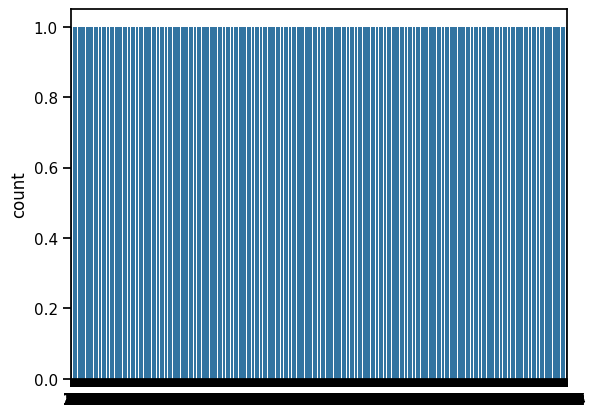

In [6]:
def data_distribution(df):
    if run_from_ipython():
        plt.figure()
        sns.countplot(df.index)
    cnt = collections.Counter(df.index)
    print(cnt)
    return np.array([cnt[i] for i in range(len(cnt))])

print(class2label)
data_dict = np2df(X, y)
print(data_dict)
y_count = data_distribution(data_dict)
# y_count = data_distribution(np2df(X, y))

In [7]:
# Training procedure

train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []
fi_list = []

# Model parameters
clf_params = get_params(model)
if model not in ['ab', 'svm']:
    clf_params['n_jobs'] = n_jobs
print('Hyper-parameters:')
print(clf_params)

# Declare K-Fold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Normalize data
# Note that decision tree sbased algorithms need no data normalization
if model in ['lr', 'p', 'svm']:
    print('Normalizing data...')
    X = np.nan_to_num(X / np.abs(X).max(axis=0))

# Start cross validation
for train_idx, valid_idx in tqdm(skf.split(X, y)):
    # print(train_idx[:100], valid_idx[:10])
    
    # Retrieve splitted training set and validating set
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Calculate sample weight (whether to apply cost sensitive learning)
    sample_weight = np.ones((len(y_train), ), dtype='float64')
    if cost_sensitive:
        sample_weight = class_weight.compute_sample_weight('balanced', y_train)
    
    # Declare the classifier and train it on the training set
    clf = get_model(model, clf_params)
    # clf.fit(X_train, y_train)
    clf.fit(X_train, y_train, sample_weight=sample_weight)
    
    # Evaluate on the training set
    y_pred = clf.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    train_cm_list.append(cm)
    rp = classification_report(y_train, y_pred, target_names=class_names, output_dict=True)
    train_rp_list.append(rp)
    
    # Evaluate on the validating set
    y_pred = clf.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)
    
    # Get the feature importances according to the trained model
    if model in ['rf', 'xgb', 'lgb']:
        if 'booster' in clf_params and clf_params['booster'] == 'dart':
            pass
        else:
            fi = clf.feature_importances_
            fi_list.append(fi)

Hyper-parameters:
{'n_estimators': 1000, 'importance_type': 'gain', 'n_jobs': 10}


10it [01:00,  6.07s/it]


In [8]:
# Save training results

experiment_name = os.path.join(result_path, '{}.{}.{}'.format(model, feature_type, scheme))
if not cost_sensitive:
    experiment_name += '.no_cs'
results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

Average confusion matrix of training set in 10-fold


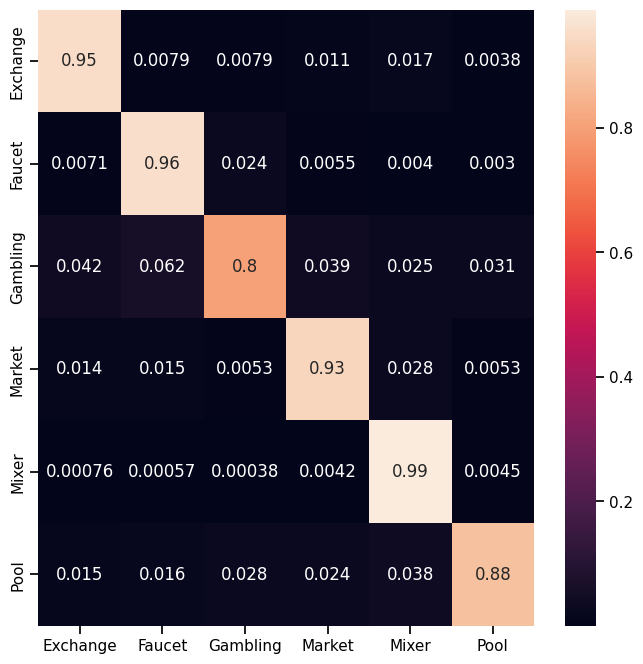

In [9]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [10]:
def show_rp_list(rp_list):
    # Initialize a dictionary to hold the summed metrics
    summed_metrics = {}
    
    # Iterate over each report in the list
    for report in rp_list:
        for category, metrics in report.items():
            # Check if metrics is a dictionary
            if isinstance(metrics, dict):
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value
            else:
                # Handle the case where metrics is a float (like 'accuracy')
                if category not in summed_metrics:
                    summed_metrics[category] = 0
                summed_metrics[category] += metrics

    # Now calculate the average
    avg_metrics = {}
    for category, metrics in summed_metrics.items():
        if isinstance(metrics, dict):
            avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        else:
            # Average for float values
            avg_metrics[category] = metrics / len(rp_list)

    # Print the average metrics
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        else:
            print(f"  Value: {metrics}")
        print()

# Average classification report of training set in K-fold

print('Average classification report of training set in {:d}-fold'.format(n_folds))
show_rp_list(train_rp_list)

Average classification report of training set in 10-fold
Category: Exchange
  precision: 0.852947728188963
  recall: 0.9516594516594516
  f1-score: 0.8995657361585472

Category: Faucet
  precision: 0.8485340386321404
  recall: 0.9566310442174462
  f1-score: 0.8992933950884092

Category: Gambling
  precision: 0.9564400380690173
  recall: 0.801508665103683
  f1-score: 0.8720899159355577

Category: Market
  precision: 0.8635224450770573
  recall: 0.9325757575757576
  f1-score: 0.8966965210412031

Category: Mixer
  precision: 0.7991830991459274
  recall: 0.9895897777395886
  f1-score: 0.8841973545601434

Category: Pool
  precision: 0.94300927149059
  recall: 0.8782505910165487
  f1-score: 0.9094598735259781

Category: accuracy
  Value: 0.8919530413092451

Category: macro avg
  precision: 0.877272770100616
  recall: 0.9183692145520792
  f1-score: 0.8935504660516397

Category: weighted avg
  precision: 0.8995564953089474
  recall: 0.8919530413092451
  f1-score: 0.8915330223795424



Average confusion matrix of validataion set in 10-fold


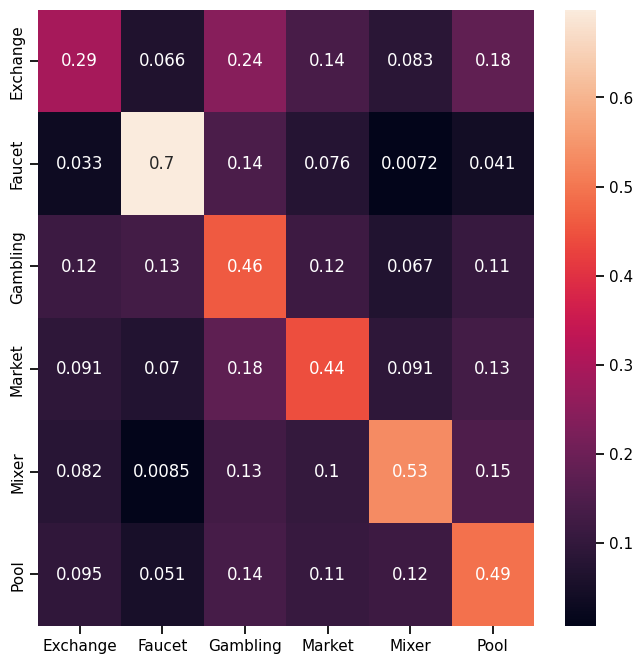

In [11]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

In [12]:
# Average classification report of validataion set in K-fold

print('Average classification report of validataion set in {:d}-fold'.format(n_folds))
show_rp_list(valid_rp_list)

Average classification report of validataion set in 10-fold
Category: Exchange
  precision: 0.2956674660582007
  recall: 0.29090909090909084
  f1-score: 0.2928503339613716

Category: Faucet
  precision: 0.600548673992553
  recall: 0.6982221754681255
  f1-score: 0.6446372787720159

Category: Gambling
  precision: 0.5544038801806783
  recall: 0.45835919412836795
  f1-score: 0.5011272513582343

Category: Market
  precision: 0.38306841301137373
  recall: 0.4420454545454546
  f1-score: 0.4089185715702152

Category: Mixer
  precision: 0.40817878017979287
  recall: 0.5315897136177674
  f1-score: 0.46117716546775744

Category: Pool
  precision: 0.5379488810865894
  recall: 0.4921985815602836
  f1-score: 0.5133971357121675

Category: accuracy
  Value: 0.4855305838739573

Category: macro avg
  precision: 0.46330268241819805
  recall: 0.4855540350381816
  f1-score: 0.4703512894736271

Category: weighted avg
  precision: 0.49196861454148905
  recall: 0.4855305838739573
  f1-score: 0.48479812254773

gain
[ 0 45 26 40 44 27 36 41 38 47 46 42 43 32 39 34 37 29  3 20  1  2 19 18
 17 16 15 12 13  4  5  6  7 22  8  9 10 11 14 21 63 23 52 61 60 59 58 57
 56 55 54 53 51 24 50 49 48 35 33 62 30 28 25 31]


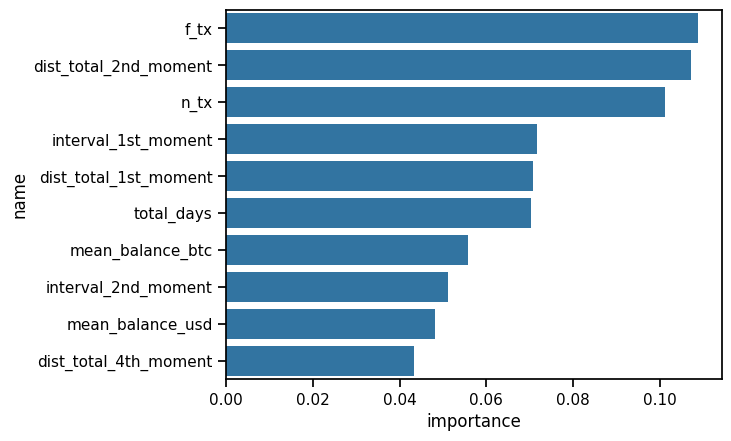

In [13]:
# Feature Importance

if len(fi_list) == 0:
    exit()
    sys.exit()

try:
    print(clf.importance_type)
except Exception as e:
    print(e)

fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_top_10 = df_feature_importances.nlargest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_top_10)  # Modified this line


In [14]:
if run_from_ipython():
    plt.figure(figsize=(16, 32))
    for i in range(10):
        feature_index = df_top_10.index[i]
        feature_name = list(df_top_10['name'])[i]
        feature_data = X[:, feature_index]

        # Check if the lengths match
        if len(y_names) != len(feature_data):
            print(f"Length mismatch for feature '{feature_name}': Length of y_names is {len(y_names)}, length of feature data is {len(feature_data)}")
            continue  # Skip this iteration

        plt.subplot(5, 2, i+1)
        plt.title(feature_name)
        ax = sns.boxplot(x=y_names, y=feature_data)


Length mismatch for feature 'f_tx': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'dist_total_2nd_moment': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'n_tx': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'interval_1st_moment': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'dist_total_1st_moment': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'total_days': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'mean_balance_btc': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'interval_2nd_moment': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'mean_balance_usd': Length of y_names is 6, length of feature data is 6636
Length mismatch for feature 'dist_total_4th_moment': Length of y_names is 6, length of 

<Figure size 1600x3200 with 0 Axes>

[ 0 45 26 40 44 27 36 41 38 47 46 42 43 32 39 34 37 29  3 20  1  2 19 18
 17 16 15 12 13  4  5  6  7 22  8  9 10 11 14 21 63 23 52 61 60 59 58 57
 56 55 54 53 51 24 50 49 48 35 33 62 30 28 25 31]


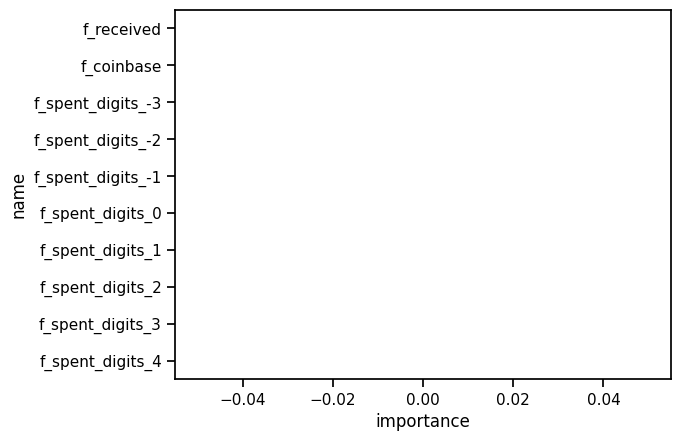

In [15]:
fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_least_10 = df_feature_importances.nsmallest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_least_10)  # Corrected this line


[ 0 45 26 40 44 27 36 41 38 47 46 42 43 32 39 34 37 29  3 20  1  2 19 18
 17 16 15 12 13  4  5  6  7 22  8  9 10 11 14 21 63 23 52 61 60 59 58 57
 56 55 54 53 51 24 50 49 48 35 33 62 30 28 25 31]


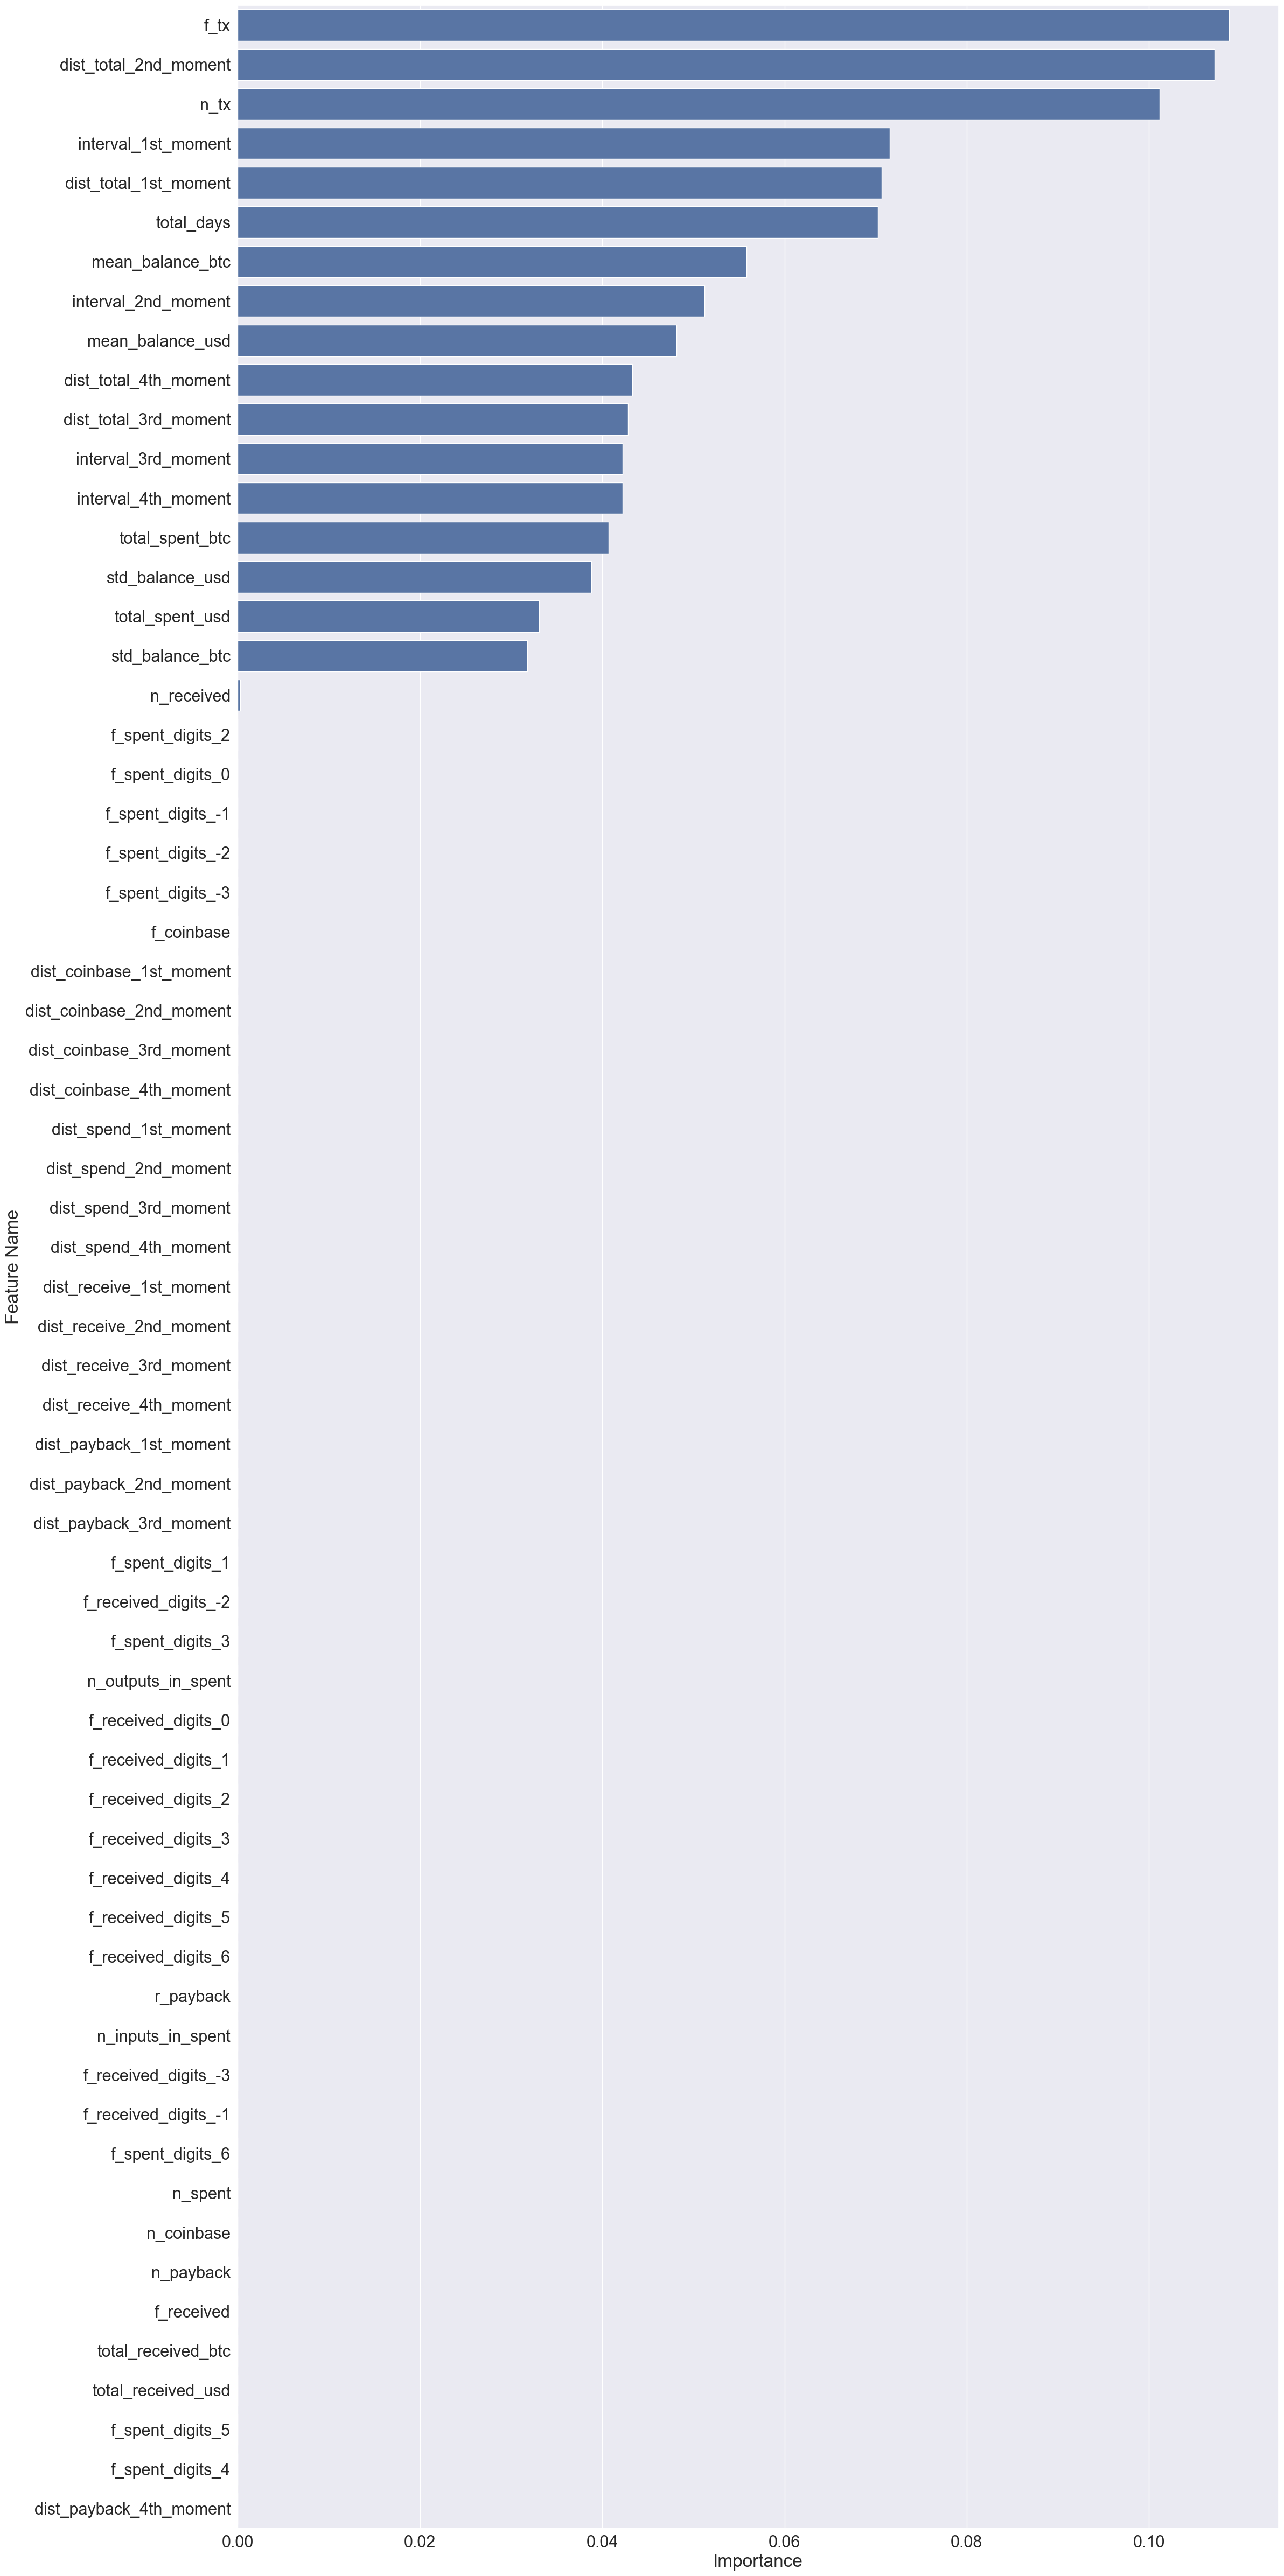

In [16]:
fi_avg = np.mean(fi_list, axis=0)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'Feature Name': features, 'Importance': fi_avg})
    df_least_10 = df_feature_importances.nlargest(len(features), columns='Importance')
    plt.figure(figsize=(24, 48))
    sns.set(font_scale=2)
    sns.barplot(x='Importance', y='Feature Name', data=df_least_10)  # Corrected this line
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('top_10_and_last_10_feature_importance.png')  # Uncomment this line to save the figure


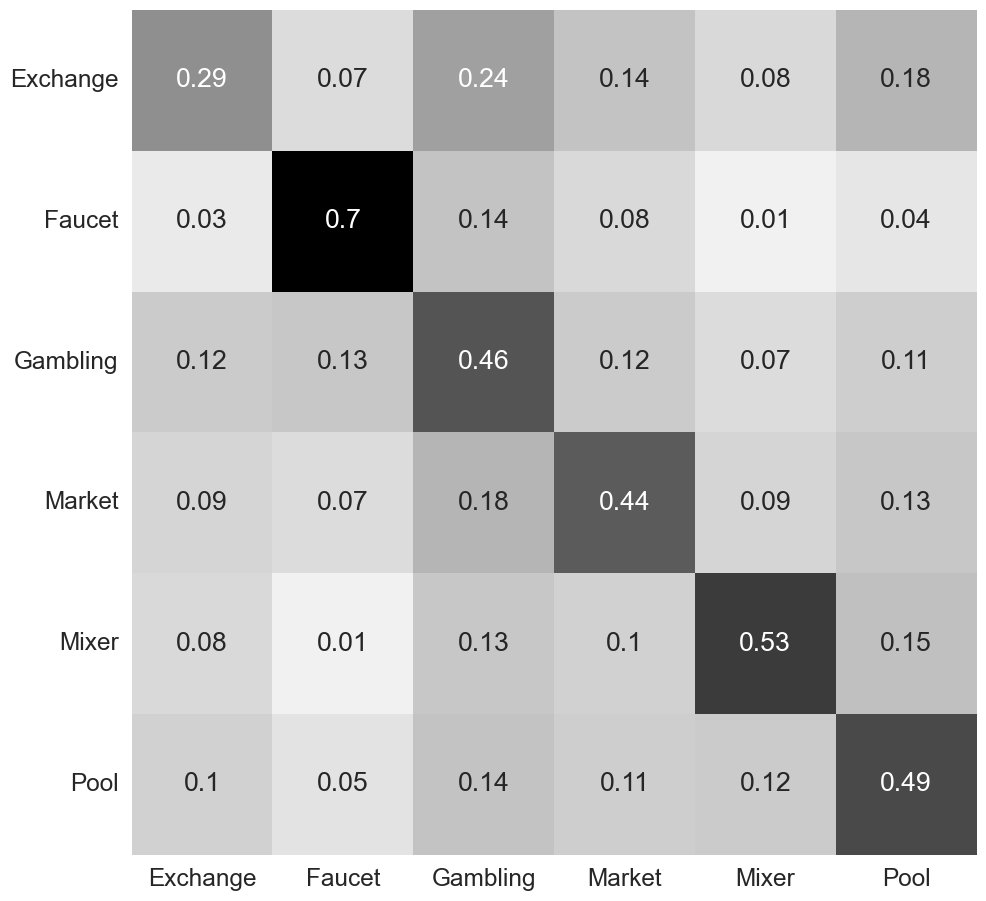

In [17]:
from matplotlib.colors import ListedColormap

cm_avg = np.mean(valid_cm_list, axis=0)
# print(cm_avg)
if run_from_ipython():
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 10))
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.light_palette('black', as_cmap=True)
    # cmap = ListedColormap(['white'])
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('confusion_matrix.png')  # Uncomment this line to save the figure